In [15]:
# setup - make functions for easy comparison of different settings (parameters) later
import sklearn.datasets as datasets
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os



# generate one of the given sklearn datasets ; options are:
#   1: blobs - generate n-dimensional blobs
#   2: circles - generate concentric circles in 2D space
#   3: moons - generate two half moons in 2D space
#   4: scurve - generate an S curve
#   5: generate a swiss roll
# dimensions and blobCount parameters only apply to blobs
def generateData(n, dataset, noise = 0.0, dimensions=2, blobCount=2):
  if dataset == "blobs":
    return datasets.make_blobs(n, n_features = dimensions, centers=blobCount, cluster_std=noise+1)
  if dataset == "circles":
    return datasets.make_circles(n, noise=noise)
  if dataset == "moons":
    return datasets.make_moons(n, noise=noise)
  if dataset == "scurve":
    return datasets.make_s_curve(n, noise=noise)
  if dataset == "swiss":
    return datasets.make_swiss_roll(n)

# given a dataset X, treat each point as a node in a graph and calculate the euclidian
#   distance between each node
def generateDistMtx(X):
  return cdist(X, X)


# apply a given kernel to the distance matrix to generate an affinity matrix for the graph
def generateAffinityMtx(distX, kernel, std=0.1):
  if kernel == "nearestNeighbors":
    return distX < np.average(distX) / 5
  if kernel == "gaussian":
    scale = 1 / (2*(std**2))
    return np.exp(-1 * scale * (distX**2))


# Find "degree" matrix by summing rows of affinity matrix (ith row corresponds to ith node, so the 
#   sum of the ith row is the degree measure of the ith node, and the degree measure is based on the measure used
#   for the affinity matrix)
# The degree matrix is expressed as a diagonal matrix containing the degrees of each node
def generateDegreeMtx(affX):
  degrees = np.sum(affX, axis=1)
  return np.diag(degrees)


# Find the laplacian matrix by subtracting the affinity matrix from the degree matrix, then obtain
#   its eigenvectors. Since we are working with 2D data, we take the first 2 eigenvectors (corresponding
#   to the smallest eigenvalues) as the new dataset (the ith element of the new dataset is the new feature
#   vector of the ith element of the original dataset). For the sake of experimentation, the Laplacian matrix
#   was normalized for testing.
def generateLaplacianEigenvectors(degX, affX, nClusters, normalized = True):
    L = degX - affX
    
    if normalized:
        deg_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(affX, axis=1)))
        L = np.dot(deg_inv_sqrt, np.dot(L, deg_inv_sqrt))
        
    W, V = np.linalg.eig(L)
    newData = V[:, W.argsort()]
    newData = newData[:, :nClusters]
    return newData.real

 

# The ith data element of the new data corresponds to the (transformed version of the) ith data element of the 
#   original data (obtained from generateData()). Using this new data, this function fits a clustering model
#   and returns the predictions; these predictions exactly correspond to predictions for the original dataset
def generatePredictions(newDataset, classifier, nClusters):
  if classifier == "kmeans":
    model = KMeans(nClusters)
    model.fit(newDataset)
    return model.labels_


# plot the data with the given labels
def plotClusters(data, labels, is3D=False, filename = None):
  if not is3D:
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    plt.show()
  if is3D:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels)
    

  if filename is not None:
    if not os.path.exists('images'):
        os.makedirs('images')
    plt.savefig(os.path.join("images", filename))
    
  plt.show()
  


# Using all the functions defined above, run the spectral clustering algorithm on a general dataset
def executeSpectralClustering(X, nClusters, kernel="gaussian", std=.08, is3D=False):
  dist = generateDistMtx(X)
  A = generateAffinityMtx(dist, kernel, std)
  D = generateDegreeMtx(A)
  newData = generateLaplacianEigenvectors(D, A, nClusters, normalized = True)
  labels = generatePredictions(newData, "kmeans", nClusters)
  #plotClusters(X, labels, is3D)
  return labels



In [16]:
# Runs the Sklearn implementation of the K-means algorithm
def run_k_means(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    k_labels = kmeans.labels_
    return k_labels

In [17]:
# This function creates 100 sample points of the adjusted random index for each algorithm with varying levels of noise
# and returns a Pandas data frame with a column for the level of noise, the ARI results for k-means, and the results for 
# spectral clustering.
def test_noise_sensitivity(dataset, nPoints, kernel, std, is3D, dimensions = 2, blobCount = 2):
    noise_levels = np.linspace(0, 1, 100)
    k_ari_scores = []
    s_ari_scores = []

    for noise in noise_levels:
        X, y = generateData(nPoints, dataset, noise, dimensions, blobCount)
        nClusters = np.size(np.unique(y))
        
        k_labels = run_k_means(nClusters, X)
        s_labels = executeSpectralClustering(X, nClusters, kernel, std, is3D)

        k_ari = adjusted_rand_score(y, k_labels)
        k_ari_scores.append(k_ari)
        
        s_ari = adjusted_rand_score(y, s_labels)
        s_ari_scores.append(s_ari)


    df = pd.DataFrame({'Noise Level': noise_levels,
                       'K-means ARI': k_ari_scores,
                       'Spectral ARI': s_ari_scores})
    return df

In [18]:
# This function uses the information obtained in the test_noise_sensitivity function to create quartile averages
# of the ARI for each algorithm 
def plot_noise_quartiles(df):
    df['Quartile'] = pd.qcut(df['Noise Level'], 4, labels=False)
    quartile_averages = df.groupby('Quartile').mean()
    plt.plot(quartile_averages.index, quartile_averages['K-means ARI'], marker='o', label='K-means ARI')
    plt.plot(quartile_averages.index, quartile_averages['Spectral ARI'], marker='o', label='Spectral ARI')

    plt.xlabel('Quartile')
    plt.ylabel('ARI')
    plt.title('Quartile Averages of ARI for K-means and Spectral Clustering')
    plt.legend()
    plt.xticks(range(4), ['Q1', 'Q2', 'Q3', 'Q4'])
    plt.show()

In [47]:
# This function creates 100 sample points of ARI for a given data set and parameters with the goal of generating a 
# sample mean and a confidence interval for the ARI. 
def generate_samples(n_samples=100, n_points=500, dataset = 'blobs', dimensions=2, blobCount=2, kernel="gaussian", std=0.08, is3D=False):
    k_means_ari_scores = []
    spectral_ari_scores = []

    for _ in range(n_samples):
        # Generate dataset
        X, y_true = generateData(n_points, dataset, 0.02, dimensions, blobCount)
        n_clusters = np.size(np.unique(y))
        
        # K-means clustering
        kmeans = KMeans(n_clusters)
        kmeans.fit(X)
        y_kmeans = kmeans.labels_
        k_means_ari = adjusted_rand_score(y_true, y_kmeans)
        k_means_ari_scores.append(k_means_ari)

        # Spectral clustering
        y_spectral = executeSpectralClustering(X, n_clusters, kernel, std, is3D)
        spectral_ari = adjusted_rand_score(y_true, y_spectral)
        spectral_ari_scores.append(spectral_ari)

    return k_means_ari_scores, spectral_ari_scores

In [20]:
# Generates the confidence interval of the sample mean
def confidence_interval(samples, confidence=0.95):
    sample_mean = np.mean(samples)
    sample_std = np.std(samples, ddof=1)
    n = len(samples)
    standard_error = sample_std / np.sqrt(n)

    z_critical = stats.norm.ppf((1 + confidence) / 2)
    margin_of_error = z_critical * standard_error

    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    return sample_mean, lower_bound, upper_bound

True labels: 


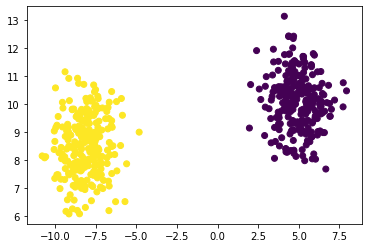

<Figure size 432x288 with 0 Axes>

Spectral clustering results: 


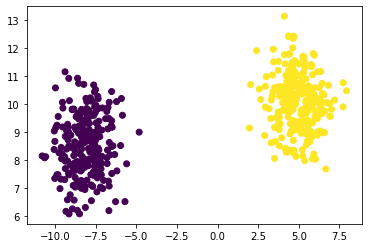

<Figure size 432x288 with 0 Axes>

K-means Clustering Results: 


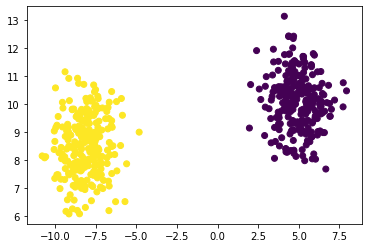

<Figure size 432x288 with 0 Axes>

Performance Comparison:

K-means Clustering ARI: 1.0
Spectral Clustering ARI: 1.0


In [21]:
### Spectral clustering on 2D blobs with a gaussian kernel ###

nPoints = 500
kernel = "gaussian"
std = 1/math.sqrt(2)
is3D = False

# generate 2 blobs of data in 2D
X, y = generateData(nPoints, "blobs", dimensions=2, blobCount=2)
nClusters = np.size(np.unique(y))

# plot true labels vs labels obtained from spectral clustering:
print("True labels: ")
plotClusters(X, y, is3D, '2D_blobs_true.png')

print("Spectral clustering results: ")
spectral_labels = executeSpectralClustering(X, nClusters, kernel, std, is3D)
plotClusters(X, spectral_labels, is3D, '2D_blobs_spectral.png')

k_labels = run_k_means(nClusters, X)
print("K-means Clustering Results: ")
plotClusters(X, k_labels, is3D, '2D_blobs_kmeans.png')


k_ari = adjusted_rand_score(y, k_labels)
s_ari = adjusted_rand_score(y, spectral_labels)
print("Performance Comparison:\n")
print('K-means Clustering ARI: ' + str(k_ari))
print('Spectral Clustering ARI: ' + str(s_ari))

In [40]:
k_means_samples, spectral_samples = generate_samples(dataset ="blobs", dimensions=2, blobCount=2, kernel=kernel, std=std, is3D=is3D)

k_means_mean, k_means_lower, k_means_upper = confidence_interval(k_means_samples)
spectral_mean, spectral_lower, spectral_upper = confidence_interval(spectral_samples)

print(f"K-means ARI sample mean: {k_means_mean:.4f}, confidence interval: ({k_means_lower:.4f}, {k_means_upper:.4f})")
print(f"Spectral ARI sample mean: {spectral_mean:.4f}, confidence interval: ({spectral_lower:.4f}, {spectral_upper:.4f})")

K-means ARI sample mean: 0.9341, confidence interval: (0.8940, 0.9742)
Spectral ARI sample mean: 0.0000, confidence interval: (0.0000, 0.0000)


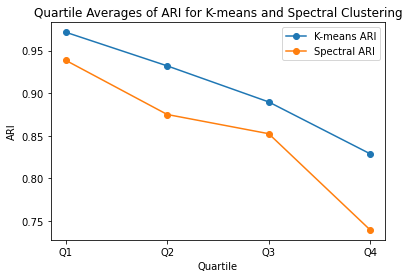

In [23]:
df = test_noise_sensitivity("blobs", nPoints, kernel, std, is3D, 2, 2)
plot_noise_quartiles(df)

True labels: 


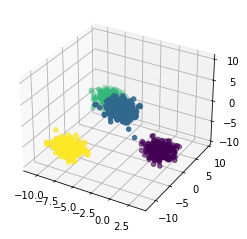

Spectral clustering results: 


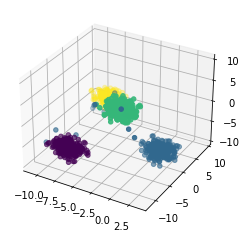

K-means Clustering Results: 


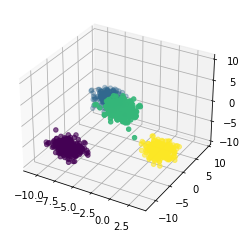

Performance Comparison:

K-means Clustering ARI: 1.0
Spectral Clustering ARI: 0.9519964770955258


In [26]:
### Spectral clustering on 3D blobs with a gaussian kernel ###

nPoints = 1000
kernel = "gaussian"
std = 1/math.sqrt(2)
is3D = True

# generate 4 blobs of data in 3D
X, y = generateData(nPoints, "blobs", dimensions=3, blobCount=4)
nClusters = np.size(np.unique(y))

# plot true labels vs labels obtained from spectral clustering:
print("True labels: ")
plotClusters(X, y, is3D, '3D_blobs_true.png')

print("Spectral clustering results: ")
spectral_labels =executeSpectralClustering(X, nClusters, kernel, std, is3D)
plotClusters(X, spectral_labels, is3D, '3D_blobs_spectral.png')

k_labels = run_k_means(nClusters, X)
print("K-means Clustering Results: ")
plotClusters(X, k_labels, is3D, '3D_blobs_kmeans.png')

k_ari = adjusted_rand_score(y, k_labels)
s_ari = adjusted_rand_score(y, spectral_labels)
print("Performance Comparison:\n")
print('K-means Clustering ARI: ' + str(k_ari))
print('Spectral Clustering ARI: ' + str(s_ari))

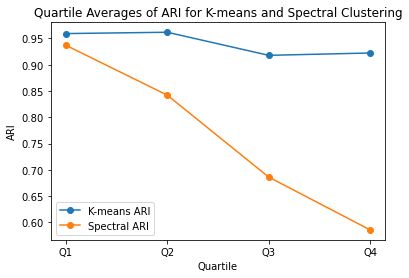

In [27]:
df = test_noise_sensitivity("blobs", nPoints, kernel, std, is3D, 3, 4)
plot_noise_quartiles(df)

In [28]:
k_means_samples, spectral_samples = generate_samples(dataset ="blobs", dimensions=3, blobCount=4, kernel=kernel, std=std, is3D=is3D)

k_means_mean, k_means_lower, k_means_upper = confidence_interval(k_means_samples)
spectral_mean, spectral_lower, spectral_upper = confidence_interval(spectral_samples)

print(f"K-means ARI sample mean: {k_means_mean:.4f}, confidence interval: ({k_means_lower:.4f}, {k_means_upper:.4f})")
print(f"Spectral ARI sample mean: {spectral_mean:.4f}, confidence interval: ({spectral_lower:.4f}, {spectral_upper:.4f})")

K-means ARI sample mean: 0.9835, confidence interval: (0.9747, 0.9923)
Spectral ARI sample mean: 0.9635, confidence interval: (0.9472, 0.9798)


True labels: 


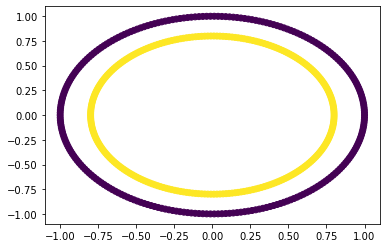

<Figure size 432x288 with 0 Axes>

Spectral clustering results: 


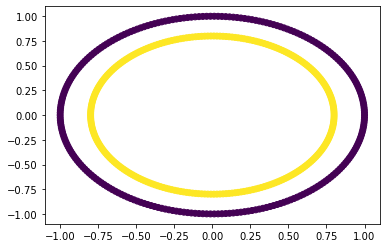

<Figure size 432x288 with 0 Axes>

K-means Clustering Results: 


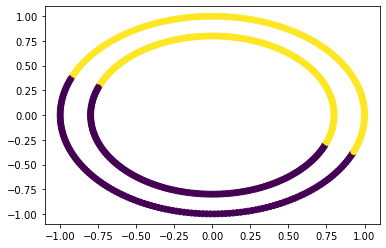

<Figure size 432x288 with 0 Axes>

Performance Comparison:

K-means Clustering ARI: -0.002008032128514056
Spectral Clustering ARI: 1.0


In [48]:
### Spectral clustering on 2D circles with a gaussian kernel ###

nPoints = 500
kernel = "gaussian"
std = .009
is3D = False

# generate 2 concentric circles in 2D
X, y = generateData(nPoints, "circles")
nClusters = np.size(np.unique(y))

# plot true labels vs labels obtained from spectral clustering:
print("True labels: ")
plotClusters(X, y, is3D, 'circles_true.png')

print("Spectral clustering results: ")
spectral_labels = executeSpectralClustering(X, nClusters, kernel, std, is3D)
plotClusters(X, spectral_labels, is3D, 'circles_spectral.png')

k_labels = run_k_means(nClusters, X)
print("K-means Clustering Results: ")
plotClusters(X, k_labels, is3D, 'circles_kmeans.png')

k_ari = adjusted_rand_score(y, k_labels)
s_ari = adjusted_rand_score(y, spectral_labels)
print("Performance Comparison:\n")
print('K-means Clustering ARI: ' + str(k_ari))
print('Spectral Clustering ARI: ' + str(s_ari))

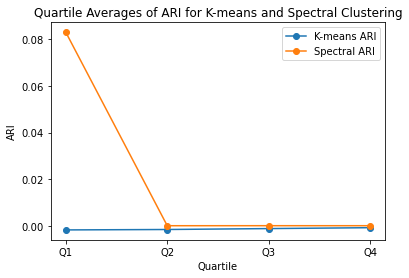

In [31]:
df = test_noise_sensitivity("circles", nPoints, kernel, std, is3D)
plot_noise_quartiles(df)

In [49]:
k_means_samples, spectral_samples = generate_samples(dataset ="circles", kernel=kernel, std=std, is3D=is3D)

k_means_mean, k_means_lower, k_means_upper = confidence_interval(k_means_samples)
spectral_mean, spectral_lower, spectral_upper = confidence_interval(spectral_samples)

print(f"K-means ARI sample mean: {k_means_mean:.4f}, confidence interval: ({k_means_lower:.4f}, {k_means_upper:.4f})")
print(f"Spectral ARI sample mean: {spectral_mean:.4f}, confidence interval: ({spectral_lower:.4f}, {spectral_upper:.4f})")

K-means ARI sample mean: -0.0020, confidence interval: (-0.0020, -0.0020)
Spectral ARI sample mean: 0.1976, confidence interval: (0.1394, 0.2557)


True labels: 


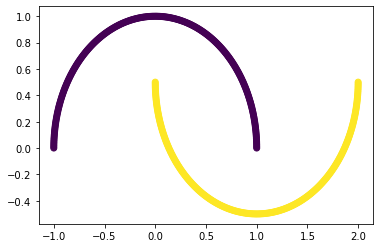

Spectral clustering results: 


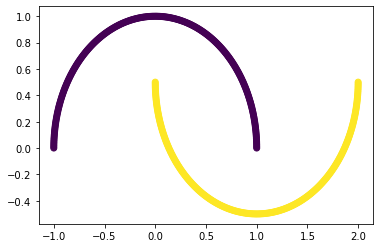

K-means Clustering Results: 


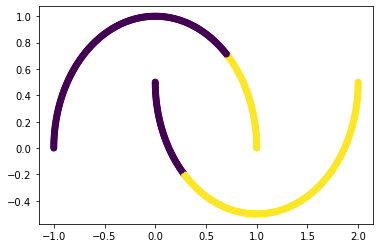

Performance Comparison:

K-means Clustering ARI: 0.25251804016064255
Spectral Clustering ARI: 1.0


In [50]:
### Spectral clustering on 2D half-moons with a gaussian kernel ###

nPoints = 500
kernel = "gaussian"
std = .01
is3D = False

# generate 2 half-moons in 2D
X, y = generateData(nPoints, "moons")
nClusters = np.size(np.unique(y))

# plot true labels vs labels obtained from spectral clustering:
print("True labels: ")
plotClusters(X, y, is3D)

print("Spectral clustering results: ")
spectral_labels = executeSpectralClustering(X, nClusters, kernel, std, is3D)
plotClusters(X, spectral_labels, is3D)

k_labels = run_k_means(nClusters, X)
print("K-means Clustering Results: ")
plotClusters(X, k_labels, is3D)

k_ari = adjusted_rand_score(y, k_labels)
s_ari = adjusted_rand_score(y, spectral_labels)
print("Performance Comparison:\n")
print('K-means Clustering ARI: ' + str(k_ari))
print('Spectral Clustering ARI: ' + str(s_ari))

In [51]:
k_means_samples, spectral_samples = generate_samples(dataset ="moons", kernel=kernel, std=std, is3D=is3D)

k_means_mean, k_means_lower, k_means_upper = confidence_interval(k_means_samples)
spectral_mean, spectral_lower, spectral_upper = confidence_interval(spectral_samples)

print(f"K-means ARI sample mean: {k_means_mean:.4f}, confidence interval: ({k_means_lower:.4f}, {k_means_upper:.4f})")
print(f"Spectral ARI sample mean: {spectral_mean:.4f}, confidence interval: ({spectral_lower:.4f}, {spectral_upper:.4f})")

K-means ARI sample mean: 0.2505, confidence interval: (0.2492, 0.2518)
Spectral ARI sample mean: 0.9910, confidence interval: (0.9756, 1.0063)


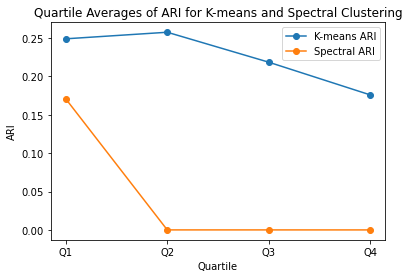

In [52]:
df = test_noise_sensitivity("moons", nPoints, kernel, std, is3D)
plot_noise_quartiles(df)

In [ ]:
### Spectral clustering on a 3D "S-curve" with a gaussian kernel ###

nPoints = 4000
kernel = "gaussian"
std = .07
is3D = True

# generate an S-curve in 3D - note that there are no labels given with this dataset, so
#   we just set the number of perceived clusters to be 3, which works relatively well in this
#   visualization (since there are 3 main sections of the curve)
X, _ = generateData(nPoints, "scurve")
nClusters = 3

# plot labels obtained from clustering the s-curve with 3 clusters
print("Spectral clustering results: ")
executeSpectralClustering(X, nClusters, kernel, std, is3D)

In [ ]:
### Spectral clustering on 3D "swiss roll" with a gaussian kernel ###

nPoints = 4000
kernel = "gaussian"
std = 1/math.sqrt(2)
is3D = True

# Generate a swiss roll of data points in 3D
# Note that there are no labels for this data, so we set the number of clusters to 3, and it clusters
#   along the direction of the swiss roll. This is similar to the concentric circles in 2D, and shows
#   another advantage of spectral clustering vs a radial clustering algorithm
X, _ = generateData(nPoints, "swiss")
nClusters = 3

# plot labels obtained from spectral clustering
print("Spectral clustering results: ")
executeSpectralClustering(X, nClusters, kernel, std, is3D)

In [55]:
nPoints = 1000
kernel = "gaussian"
std = 1/math.sqrt(2)
is3D = True

k_ari_values = []
s_ari_values = []

# This code snippet generates a sample for the ARI for each algorithm given a data set of three 
# clusters existing in a five-dimensional space. Some noise was introduced.

for _ in range(100):
    X, y = generateData(nPoints, "blobs", noise = 0.1, dimensions=5, blobCount=3)
    nClusters = np.size(np.unique(y))

    spectral_labels = executeSpectralClustering(X, nClusters, kernel, std, is3D)
    k_labels = run_k_means(nClusters, X)

    k_ari = adjusted_rand_score(y, k_labels)
    s_ari = adjusted_rand_score(y, spectral_labels)

    k_ari_values.append(k_ari)
    s_ari_values.append(s_ari)

print("Performance Comparison:\n")
k_means_mean, k_means_lower, k_means_upper = confidence_interval(k_ari_values)
spectral_mean, spectral_lower, spectral_upper = confidence_interval(s_ari_values)

print(f"K-means ARI sample mean: {k_means_mean:.4f}, confidence interval: ({k_means_lower:.4f}, {k_means_upper:.4f})")
print(f"Spectral ARI sample mean: {spectral_mean:.4f}, confidence interval: ({spectral_lower:.4f}, {spectral_upper:.4f})")

Performance Comparison:

K-means ARI sample mean: 0.9984, confidence interval: (0.9966, 1.0003)
Spectral ARI sample mean: 0.9776, confidence interval: (0.9598, 0.9954)
